In [8]:
import pandas as pd
import pickle
import numpy as np
from collections import Counter
from typing import List, Tuple, Dict
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

p = r'../data/Amazon-reviews/train.ft.txt'
with open(p, 'r', encoding='utf8') as f:
    train_data = f.readlines()

df_train = []
for line in train_data:
    temp = []
    if '__label__2 ' in line:
        review = line.split('__label__2 ')[1].strip()
        temp = [review, 0]

    elif '__label__1 ' in line:
        review = line.split('__label__1 ')[1].strip()
        temp = [review, 1]
    else:
        print(f'error {f}')
    df_train.append(temp)

df_train = pd.DataFrame(df_train, columns=['review', 'sentiment'])
print(df_train.shape, df_train['sentiment'].value_counts())
df_train.to_csv(r'../data/Amazon_review-train.csv', index=False)

df_train = df_train.sample(frac=1, random_state=1).reset_index(drop=True)
df_train = df_train.iloc[:100000]
print(df_train.shape, df_train['sentiment'].value_counts())
df_train.to_csv(r'../data/Amazon_review-sample-train.csv', index=False)

df_train.head()

(3600000, 2) 0    1800000
1    1800000
Name: sentiment, dtype: int64
(100000, 2) 0    50067
1    49933
Name: sentiment, dtype: int64


,review,sentiment
0,Excellent home help for parents: Volume 1 of D...,0
1,"Stay far, far away.: I made it through about 6...",1
2,Lost Woods: Lost WoodsI didn't really understa...,1
3,"Renaissance -12, Women's brown suead shoes: Re...",1
4,Best Novel I've Read This Year: Intrigued by t...,0


In [9]:
p = r'../data/Amazon-reviews/test.ft.txt'
with open(p, 'r', encoding='utf8') as f:
    test_data = f.readlines()

df_test = []
for line in test_data:
    temp = []
    if '__label__2 ' in line:
        review = line.split('__label__2 ')[1].strip()
        temp = [review, 0]

    elif '__label__1 ' in line:
        review = line.split('__label__1 ')[1].strip()
        temp = [review, 1]
    else:
        print(f'error {f}')
    df_test.append(temp)

df_test = pd.DataFrame(df_test, columns=['review', 'sentiment'])
print(df_test.shape, df_test['sentiment'].value_counts())
df_test.to_csv(r'../data/Amazon_review-test.csv', index=False)

df_test = df_test.sample(frac=1, random_state=1).reset_index(drop=True)
df_test = df_test.iloc[:80000]
print(df_test.shape, df_test['sentiment'].value_counts())
df_test.to_csv(r'../data/Amazon_review-sample-test.csv', index=False)

df_test.head()

(400000, 2) 0    200000
1    200000
Name: sentiment, dtype: int64
(80000, 2) 1    40163
0    39837
Name: sentiment, dtype: int64


,review,sentiment
0,"Best Movie I've Seen in Years!: Okay, it was e...",0
1,Jai Uttal's voice ruins it for me.: I really e...,1
2,Disappointing: As a great fan of Elizabeth Geo...,1
3,Highway to Heaven for Vespa-holics!!: As a con...,0
4,Caveat emptor: They don't tell you that the ga...,1


In [10]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val, vocab=19998):
    word_list = []

    print("create vocab")
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    print("sorting")
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:vocab]
    # creating a dict
    onehot_dict = {w:i+1 for i, w in enumerate(corpus_)}

    print('tokenizing')
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = y_train
    encoded_test = y_val

    return final_list_train, encoded_train, final_list_test, encoded_test,onehot_dict

x_train,y_train,x_test,y_test,vocab = tokenize(x_train=df_train['review'],
                                               y_train=df_train['sentiment'],
                                               x_val=df_test['review'],
                                               y_val=df_test['sentiment'])

create vocab
sorting
tokenizing


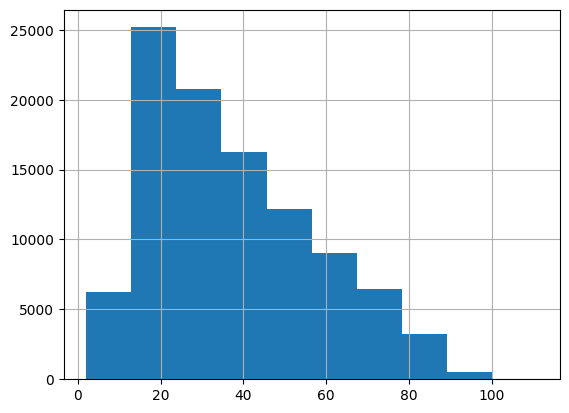

count    100000.00000
mean         37.27407
std          20.15021
min           2.00000
25%          20.00000
50%          33.00000
75%          51.00000
max         111.00000
dtype: float64

In [11]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [12]:
max_len = 100

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

x_train_pad = padding_(x_train,max_len)
x_test_pad = padding_(x_test,max_len)
print(len(x_train_pad), len(y_train))
print(len(x_test_pad), len(y_test))
print(len(x_train_pad[0]))

100000 100000
80000 80000
100


In [13]:
train_tokenized_idx = np.array(x_train_pad)
train_labels_np = np.array(y_train)
train_data = (train_tokenized_idx, train_labels_np)
print(train_tokenized_idx.shape)
print(train_labels_np.shape)

print('now dumping pickle')
with open(file='Amazon_review-sample-train.pkl', mode='wb') as f:
    pickle.dump(train_data, f)

(100000, 100)
(100000,)
now dumping pickle


In [14]:
test_tokenized_idx = np.array(x_test_pad)
test_labels_np = np.array(y_test)
test_data = (test_tokenized_idx, test_labels_np)
print(test_tokenized_idx.shape)
print(test_labels_np.shape)

print('now dumping test pickle')
# with open(file='ag_test.pkl', mode='wb') as f:
with open(file='Amazon_review-sample-test.pkl', mode='wb') as f:
    pickle.dump(test_data, f)

(80000, 100)
(80000,)
now dumping test pickle
